In [25]:
from sklearn.preprocessing import StandardScaler
import neurobayes as nb
import gpax

import jax.random as jra

from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

import random

plt.style.use('seaborn-v0_8-bright')

myrcparams = {
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'legend.title_fontsize':20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    #'figure.autolayout': True,
}
plt.rcParams.update(myrcparams)

import jax
jax.config.update("jax_enable_x64", True)

In [26]:
N = 50 # defines density of design space grid 

## Read in and merge data

In [27]:
df_1 = pd.read_csv('history.csv', index_col=0).dropna()
df_2 = pd.read_csv('new_data.csv', index_col=0).dropna()

df_1['Round'] = [1] * len(df_1)
df_2['Round'] = [2] * len(df_2)

df_all = pd.concat( [df_1, df_2], axis=0).reset_index(drop=True)
df_all

,Cu,NaOH,median_ratio,fit_A,fit_B,fit_C,Round
0,100.0,7.5,1.061765,0.863411,0.111075,1.540008,1
1,125.0,7.5,1.079406,0.913015,0.151946,1.614611,1
2,150.0,7.5,1.076986,0.823122,0.162740,1.802661,1
3,175.0,7.5,1.026320,1.000000,0.050074,1.877772,1
4,200.0,7.5,1.055157,0.917538,0.112666,1.877772,1
...,...,...,...,...,...,...,...
331,178.6,7.6,1.072848,1.728885,0.016231,1.236904,2
332,189.8,7.6,1.069268,1.750581,0.015652,1.238188,2
333,195.4,7.6,1.062827,1.729489,0.018830,1.267409,2
334,201.0,7.6,1.045532,2.119167,0.004238,1.151018,2


## Train models

In [28]:
X = df_all[ ['Cu', 'NaOH']]
targets = { 'median_ratio':'Median ratio', 'fit_A':r'$A_{fit}$', 'fit_B':r'$B_{fit}$', 'fit_C':r'$C_{fit}$'}

In [29]:
pbnn_net = nb.FlaxMLP(hidden_dims=[4, 4], target_dim=1)
rng_key_train, rng_key_predict = gpax.utils.get_keys()
model_name = 'pbnn'
model = nb.PartialBNN(pbnn_net, probabilistic_layer_names=['Dense0','Dense2'])

X_scaler, y_scaler = StandardScaler(), StandardScaler()

opts = [1.10, 'min', 'min', 'min']
results_dict = { target: {} for target in targets.keys() }
    
X_train = df_1[ ['Cu', 'NaOH'] ]
Y_train = df_1[ targets.keys() ]

X_test = df_2[ ['Cu', 'NaOH'] ]
Y_test = df_2[ targets.keys() ]

for i, (target, target_label) in enumerate(targets.items()):
    
    # Train
    X_scaler.fit(X_train)
    X_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    y_train = Y_train[target].to_numpy()
    y_scaler.fit(y_train.reshape(-1, 1))
    y_train_scaled = y_scaler.transform( y_train.reshape(-1, 1) ).reshape( y_train.shape )

    model.fit(X = X_scaled, y = y_train_scaled, num_warmup=1000, num_samples=1000, rng_key=rng_key_train) 

    # Predict on grid
    if model_name == 'bgp':
        y_pred_scaled, unc_pred_scaled = model.predict(X_new=X_grid_scaled, n = 200, rng_key=rng_key_predict)
    else:
        y_pred_scaled, unc_pred_scaled = model.predict(X_new=X_test_scaled, rng_key=rng_key_predict)
    y_pred = y_scaler.inverse_transform( y_pred_scaled.reshape(-1,1) )
    if model_name == 'bgp': # Should also add option here for gpax thompson sampling
        unc_pred_scaled =  unc_pred_scaled.std(axis=(0,1))
    unc_pred = y_scaler.inverse_transform( unc_pred_scaled.reshape(-1,1) ) 
    
    results_dict[target]['y_pred'] = y_pred.reshape( (y_pred.shape[0],) )
    results_dict[target]['uncertainty'] = unc_pred.reshape( (unc_pred.shape[0],) )


Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:00<00:00, 1084.24it/s, Epoch 500/500, LR: 0.010000, Loss: 0.3637 ]


Training partially Bayesian NN


sample: 100%|██████████| 2000/2000 [00:04<00:00, 401.01it/s, 127 steps of size 2.64e-02. acc. prob=0.88]


In [30]:
pred_df = pd.concat( (X_test.reset_index(drop=True), pd.Series( Y_test['median_ratio'] ).reset_index(drop=True), pd.Series( results_dict['median_ratio']['y_pred']).reset_index(drop=True) ), axis=1 )
pred_df.columns=['Cu', 'NaOH', 'y_true', 'y_pred']
pred_df

,Cu,NaOH,y_true,y_pred
0,144.9,4.7,1.077014,1.112207
1,150.5,4.7,1.110656,1.111832
2,156.1,4.7,1.108958,1.111440
3,161.7,4.7,1.114019,1.111033
4,167.3,4.7,1.082091,1.110610
...,...,...,...,...
87,178.6,7.6,1.072848,1.067974
88,189.8,7.6,1.069268,1.067165
89,195.4,7.6,1.062827,1.066748
90,201.0,7.6,1.045532,1.066325


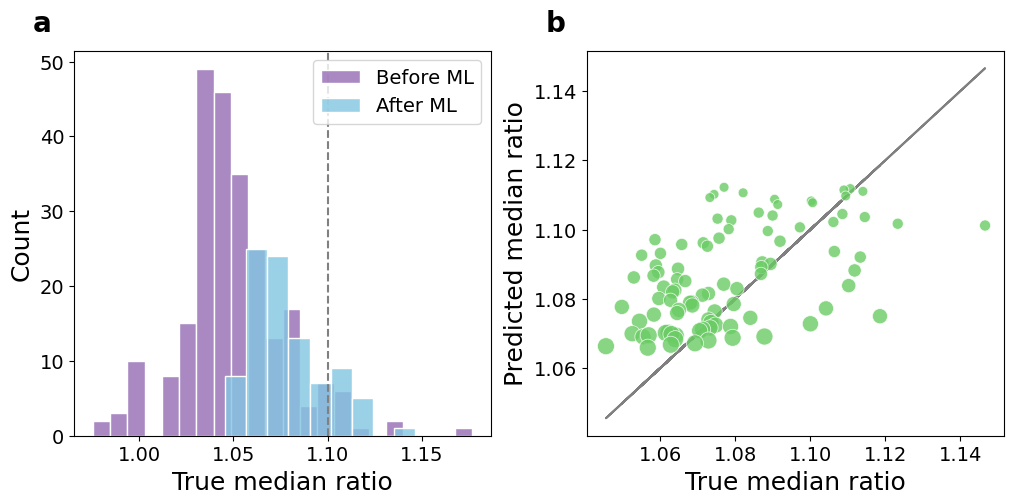

In [32]:
color = [(0.41568627450980394, 0.8, 0.39215686274509803)]
colors = [(0.5843137254901961, 0.4235294117647059, 0.7058823529411765), (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]
fig,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].axvline(1.10, color='gray', linestyle='dashed')
sns.histplot(df_1.median_ratio, color = colors[0], ec = 'white', alpha=0.8, ax=ax[0], label='Before ML')
sns.histplot(df_2.median_ratio, color = colors[1], ec = 'white', alpha=0.8, ax=ax[0], label='After ML')
ax[0].legend()
ax[1].plot(pred_df.y_true, pred_df.y_true, '-', color='gray', zorder=1)
sns.scatterplot(data=pred_df, x='y_true', y='y_pred', color=color, size='NaOH', sizes=(50, 150), alpha=0.8, legend=False, ax = ax[1], zorder=3)

ax[0].set_xlabel('True median ratio')
ax[1].set_xlabel('True median ratio')
ax[1].set_ylabel('Predicted median ratio')


ax[0].text(-0.1, 1.05, f'a', transform=ax[0].transAxes, size=20, fontweight='bold')
ax[1].text(-0.1, 1.05, f'b', transform=ax[1].transAxes, size=20, fontweight='bold')

fig.subplots_adjust(wspace=0.23)
fig.savefig('ml_iteration_1_measurements.png', dpi=600)